In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from modelbase.ode import Model, Simulator, mca

Could not find GLIMDA.


In [2]:
import math

In [3]:
#set parameters
p = {    
    # fixed concentrations (in mM)
    'NAD': 0.05,
    'NADH': 0.00002,
    'Glc': 5,
    'Pi': 1,
    'Lac':1.4,
    
    # standard Gibbs-energies of formation of all compounds (in kj/mol) for pH=7.2 and 298.15K (source: equilibrator)
    'dGf0_Glc': -412.8,
    'dGf0_P13G': -2201.8,
    'dGf0_PEP': -1191.4,
    'dGf0_Pyr': -343.3,
    'dGf0_P23G': -2239.4,
    'dGf0_ATP': -2284.2,
    'dGf0_ADP': -1409.4,
    'dGf0_AMP': -534.8,
    'dGf0_H2O': -154.4,
    'dGf0_NAD': -1173.5,
    'dGf0_NADH': -1108.9,
    'dGf0_Pi': -1057.3,
    'dGf0_Lac': -304.2,
    
    # parameters for the calculation of the Keq-values
    'R': 0.008314,   # ideal gas constant [kJ mol^-1 K^-1]  
    'T': 298.15,     # temperature in K (25°C). Assumed for dGf0-values on eQuilibrator
    'e': math.e,     # euler's number
    
    # parameters for calculation of new kcat values for the HK-PFK and PK-LDH
    'J': 1.25,             # mM/h
    'ATP_ss': 1.2,         # mM
    'ADP_ss': 0.22,        # mM
    'P13G_ss': 0.0005,     # mM
    'PEP_ss': 0.02,        # mM
    'Lac_ss': 1.4,         # mM
    'k_I_ATP': 1,          # mM
    'nH': 4,               # dimensionless
    
    # kcat values for the other reactions [h^-1]
    'k_P2GM': 1500,
    'k_P2Gase': 0.15,
    'k_PGK': 1.57*10**4,  
    'k_ATPase': 1.46,
    'k_AK_fwd': 4.0,
    'k_AK_bwd': 2.0,

}

In [4]:
#set compounds
compounds = {
    'ATP',
    'ADP',
    'P13G',
    'P23G',
    'PEP',
    'AMP',
}

In [5]:
#Instantiate model
m = Model(parameters = p, compounds = compounds)


In [6]:
# calculate standard Gibbs-energies of reaction of all lumped reactions and add them as derived parameters: 
# sum of all dGf0 of the products - sum of all dGf0 of substrates (netto)

m.add_derived_parameter(
    parameter_name='dGr0_HK_PFK', function=lambda Glc, ATP, NAD, Pi, P13G, ADP, NADH: (2*P13G + 2*ADP + 2*NADH) - (Glc + 2*ATP + 2*NAD + 2*Pi),
    parameters=['dGf0_Glc', 'dGf0_ATP', 'dGf0_NAD', 'dGf0_Pi', 'dGf0_P13G', 'dGf0_ADP', 'dGf0_NADH']
)

m.add_derived_parameter(
    parameter_name='dGr0_P2GM', function=lambda P13G, P23G: P23G - P13G, 
    parameters=['dGf0_P13G', 'dGf0_P23G']
)

m.add_derived_parameter(
    parameter_name='dGr0_PGK', function=lambda P13G, ADP, PEP, ATP, H2O: (PEP+ATP+H2O) - (P13G+ADP),
    parameters=['dGf0_P13G', 'dGf0_ADP', 'dGf0_PEP', 'dGf0_ATP', 'dGf0_H2O']
)

m.add_derived_parameter(
    parameter_name='dGr0_PK', function=lambda PEP, ADP, Pyr, ATP: (Pyr+ATP) - (PEP+ADP),
    parameters=['dGf0_PEP', 'dGf0_ADP', 'dGf0_Pyr', 'dGf0_ATP']
)

m.add_derived_parameter(
    parameter_name='dGr0_ATPase', function=lambda ATP, H2O, ADP, Pi: (ADP+Pi) - (ATP+H2O),
    parameters=['dGf0_ATP','dGf0_H2O', 'dGf0_ADP', 'dGf0_Pi']
)

m.add_derived_parameter(
    parameter_name='dGr0_P2Gase', function=lambda P23G, PEP, Pi: (PEP+Pi) - P23G,
    parameters=['dGf0_P23G', 'dGf0_PEP', 'dGf0_Pi']
)

m.add_derived_parameter(
    parameter_name='dGr0_PK_LDH', function=lambda PEP, ADP, NADH, Lac, ATP, NAD: (Lac+ATP+NAD) - (PEP + ADP + NADH),
    parameters=['dGf0_PEP', 'dGf0_ADP', 'dGf0_NADH', 'dGf0_Lac', 'dGf0_ATP', 'dGf0_NAD']
)

m.add_derived_parameter(
    parameter_name='dGr0_AK', function=lambda ATP, AMP, ADP: 2*ADP - (ATP+AMP),
    parameters=['dGf0_ATP', 'dGf0_AMP', 'dGf0_ADP']
)



In [7]:
# calculate all Keq' values, based on the standard Gibbs-energies of reaction
# Keq = e^(-dG0/RT)    R = 8.314 J mol^-1 K^-1 or 0.008314 kJ mol^-1 K^-1,   T = 298.15 K (25°C)

m.add_derived_parameter(
    parameter_name='Keq_HK_PFK', function=lambda R, T, e, dGr0_HK_PFK: e**(-((dGr0_HK_PFK)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_HK_PFK']
)

m.add_derived_parameter(
    parameter_name='Keq_P2GM', function=lambda R, T, e, dGr0_P2GM: e**(-((dGr0_P2GM)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_P2GM']
)

m.add_derived_parameter(
    parameter_name='Keq_PGK', function=lambda R, T, e, dGr0_PGK: e**(-((dGr0_PGK)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_PGK']
)

m.add_derived_parameter(
    parameter_name='Keq_PK', function=lambda R, T, e, dGr0_PK: e**(-((dGr0_PK)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_PK']
)

m.add_derived_parameter(
    parameter_name='Keq_ATPase', function=lambda R, T, e, dGr0_ATPase: e**(-((dGr0_ATPase)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_ATPase']
)

m.add_derived_parameter(
    parameter_name='Keq_P2Gase', function=lambda R, T, e, dGr0_P2Gase: e**(-((dGr0_P2Gase)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_P2Gase']
)

m.add_derived_parameter(
    parameter_name='Keq_PK_LDH', function=lambda R, T, e, dGr0_PK_LDH: e**(-((dGr0_PK_LDH)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_PK_LDH']
)

m.add_derived_parameter(
    parameter_name='Keq_AK', function=lambda R, T, e, dGr0_AK: e**(-((dGr0_AK)/(R*T))),
    parameters=['R', 'T', 'e', 'dGr0_AK']
)


In [8]:
# calculation of a new value for k_HK-PFK: same procedure as for k_PK_LDH as explained in subsection 2.2

m.add_derived_parameter(
    parameter_name='k_HK_PFK', function=lambda J, ATP_ss, k_I_ATP, nH, Glc, NAD, Pi, P13G_ss, ADP_ss, NADH, Keq_HK_PFK: 
    (J * (ATP_ss/k_I_ATP)**nH + J) / (Glc * ATP_ss**2 * NAD**2 * Pi**2 - (P13G_ss**2 * ADP_ss**2 * NADH**2)/Keq_HK_PFK),
    parameters=['J', 'ATP_ss', 'k_I_ATP', 'nH', 'Glc', 'NAD', 'Pi', 'P13G_ss', 'ADP_ss', 'NADH', 'Keq_HK_PFK']
)


In [9]:
# calculation of a new value for k_PK-LDH as explained in subsection 2.2

m.add_derived_parameter(
    parameter_name='k_PK_LDH', function=lambda J, PEP_ss, ADP_ss, NADH, Lac_ss, ATP_ss, NAD, Keq_PK_LDH: 
    2*J / (PEP_ss * ADP_ss * NADH - ((Lac_ss * ATP_ss * NAD)/Keq_PK_LDH)),
    parameters=['J', 'PEP_ss', 'ADP_ss', 'NADH', 'Lac_ss', 'ATP_ss', 'NAD', 'Keq_PK_LDH']
)

In [10]:
# show all parameters
m.get_parameters()

{'NAD': 0.05,
 'NADH': 2e-05,
 'Glc': 5,
 'Pi': 1,
 'Lac': 1.4,
 'dGf0_Glc': -412.8,
 'dGf0_P13G': -2201.8,
 'dGf0_PEP': -1191.4,
 'dGf0_Pyr': -343.3,
 'dGf0_P23G': -2239.4,
 'dGf0_ATP': -2284.2,
 'dGf0_ADP': -1409.4,
 'dGf0_AMP': -534.8,
 'dGf0_H2O': -154.4,
 'dGf0_NAD': -1173.5,
 'dGf0_NADH': -1108.9,
 'dGf0_Pi': -1057.3,
 'dGf0_Lac': -304.2,
 'R': 0.008314,
 'T': 298.15,
 'e': 2.718281828459045,
 'J': 1.25,
 'ATP_ss': 1.2,
 'ADP_ss': 0.22,
 'P13G_ss': 0.0005,
 'PEP_ss': 0.02,
 'Lac_ss': 1.4,
 'k_I_ATP': 1,
 'nH': 4,
 'k_P2GM': 1500,
 'k_P2Gase': 0.15,
 'k_PGK': 15700.0,
 'k_ATPase': 1.46,
 'k_AK_fwd': 4.0,
 'k_AK_bwd': 2.0,
 'dGr0_HK_PFK': 2.599999999998545,
 'dGr0_P2GM': -37.59999999999991,
 'dGr0_PGK': -18.799999999999727,
 'dGr0_PK': -26.699999999999818,
 'dGr0_ATPase': -28.09999999999991,
 'dGr0_P2Gase': -9.299999999999727,
 'dGr0_PK_LDH': -52.19999999999936,
 'dGr0_AK': 0.1999999999998181,
 'Keq_HK_PFK': 0.35032760626062526,
 'Keq_P2GM': 3869025.032497049,
 'Keq_PGK': 1966.9837

In [11]:
#define rate equations and add reactions 

def v_HK_PFK(ATP, P13G, ADP, k_HK_PFK, Glc, NAD, Pi, NADH, k_I_ATP, nH, Keq_HK_PFK):    
    v = k_HK_PFK * ((Glc * NAD**2 * Pi**2 * ATP**2) - (P13G**2 * ADP**2 * NADH**2)/Keq_HK_PFK) /(1+(ATP/k_I_ATP)**nH)
    return v

m.add_reaction(
    rate_name = 'v_HK_PFK',
    function = v_HK_PFK,
    stoichiometry = {'ATP': -2, 'ADP': 2, 'P13G': 2},
    modifiers = None,
    parameters = ['k_HK_PFK', 'Glc', 'NAD', 'Pi', 'NADH', 'k_I_ATP','nH', 'Keq_HK_PFK'],
    reversible = True,
)


def v_P2GM(P13G, P23G, k_P2GM, Keq_P2GM):
    v = k_P2GM * (P13G - P23G/Keq_P2GM) 
    return v

m.add_reaction(
    rate_name = 'v_P2GM',
    function = v_P2GM,
    stoichiometry = {'P13G': -1, 'P23G': 1},
    modifiers = None,
    parameters = ['k_P2GM', 'Keq_P2GM'],
    reversible = True,
)

def v_P2Gase(P23G, PEP, k_P2Gase, Keq_P2Gase):
    v = k_P2Gase * (P23G - (PEP/Keq_P2Gase))   
    return v

m.add_reaction(
    rate_name = 'v_P2Gase',
    function = v_P2Gase,
    stoichiometry = {'P23G': -1, 'PEP': 1},
    modifiers = None,
    parameters = ['k_P2Gase', 'Keq_P2Gase'],
    reversible = True,
)

def v_PGK(P13G, ADP, PEP, ATP, k_PGK, Keq_PGK):
    v = k_PGK * ((P13G*ADP)-((PEP*ATP)/Keq_PGK))  
    return v

m.add_reaction(
    rate_name = 'v_PGK',
    function = v_PGK,
    stoichiometry = {'P13G': -1, 'ADP': -1, 'PEP': 1, 'ATP': 1},
    modifiers = None,
    parameters = ['k_PGK', 'Keq_PGK'],
    reversible = True,
)

def v_PK_LDH(PEP, ADP, ATP, k_PK_LDH, NADH, Lac, NAD, Keq_PK_LDH):
    v = k_PK_LDH * ((PEP*ADP*NADH)-(Lac*ATP*NAD/Keq_PK_LDH))
    return v

m.add_reaction(
    rate_name = 'v_PK_LDH',
    function = v_PK_LDH,
    stoichiometry = {'PEP': -1, 'ADP': -1, 'ATP': 1},
    modifiers = None,
    parameters = ['k_PK_LDH', 'NADH', 'Lac', 'NAD', 'Keq_PK_LDH'],  
    reversible = True,
)

def v_AK(AMP, ATP, ADP, k_AK_fwd, Keq_AK):
    v = k_AK_fwd * ((AMP * ATP)-(ADP**2 / Keq_AK))
    return v

m.add_reaction(
    rate_name = 'v_AK',
    function = v_AK,
    stoichiometry = {'AMP': -1, 'ATP': -1, 'ADP': 2},
    modifiers = None,
    parameters = ['k_AK_fwd', 'Keq_AK'],
    reversible = True,
)

def v_ATPase(ATP, ADP, Pi, k_ATPase, Keq_ATPase):
    v = k_ATPase * (ATP-(ADP*Pi/Keq_ATPase))
    return v

m.add_reaction(
    rate_name = 'v_ATPase',
    function = v_ATPase,
    stoichiometry = {'ATP': -1, 'ADP': 1},
    modifiers = None,
    parameters = ['Pi', 'k_ATPase', 'Keq_ATPase'], 
    reversible = True,
)

In [12]:
#set initial values
y0 = {
    'P13G': 0.005,
    'P23G': 5.0,
    'PEP': 0.02,
    'AMP': 0.5,
    'ADP': 0.9,
    'ATP': 0.1 ,
}


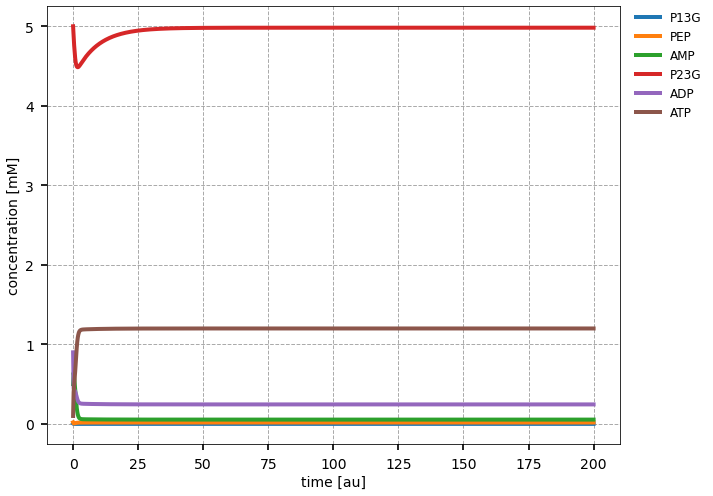

In [13]:
s = Simulator(m)
s.initialise(y0)
t, y = s.simulate(t_end=200, steps=1000)
fig, ax = s.plot(xlabel='time [au]', ylabel='concentration [mM]')
plt.show()

In [14]:
t_ss, y_ss = s.simulate_to_steady_state()

compounds_list = m.get_compounds()

summe = 0

for i in range(len(compounds_list)):
    print('{comp:<4s}:  {value:.5f} [au]'.format(comp = compounds_list[i], value = y_ss[0, i]))

P13G:  0.00050 [au]
PEP :  0.01793 [au]
AMP :  0.05438 [au]
P23G:  4.98224 [au]
ADP :  0.24537 [au]
ATP :  1.20025 [au]


In [15]:
# get fluxes

flxs = s.get_fluxes_df()
flxs

,v_HK_PFK,v_P2GM,v_P2Gase,v_PGK,v_PK_LDH,v_AK,v_ATPase
0.0,0.026678,7.498062,0.749930,70.634036,10.234118,-3.312250e+00,0.145984
0.2,0.415315,0.145530,0.730280,0.684772,1.403905,1.337436e-01,0.583313
0.4,0.594841,0.221351,0.714190,0.968107,1.676361,3.564392e-01,0.708194
0.6,0.776975,0.293205,0.700658,1.260489,1.954200,3.974461e-01,0.827533
0.8,0.977512,0.378916,0.689851,1.575802,2.257269,4.163105e-01,0.964072
...,...,...,...,...,...,...,...
199.4,1.249817,0.747273,0.747273,1.752362,2.499635,-1.524592e-11,1.752362
199.6,1.249817,0.747273,0.747273,1.752362,2.499635,-1.553063e-11,1.752362
199.8,1.249817,0.747273,0.747273,1.752362,2.499635,-1.573264e-11,1.752362
200.0,1.249817,0.747273,0.747273,1.752362,2.499635,-1.584138e-11,1.752362


## Calculate the disequilibrium of all reactions: - ln(Q/Keq)

In [16]:
# get the steady-state values of the dynamic compounds

t_ss, y_ss = s.simulate_to_steady_state()

compounds_list = m.get_compounds()

c_ss = {}

for i in range(len(compounds_list)):
    comp = compounds_list[i] 
    value = y_ss[0, i]/1000  # mM -> M  conversion from mM to M, since all energys are given in kJ/mol
    c_ss[comp] = value

In [17]:
# get the concentrations of the fixed compounds and convert them from mM to M

# define a fuction that divides by 1000 - mM -> M
def mM_M(x):
    x = x/1000
    return x

c_Glc = mM_M(p['Glc'])
c_Lac = mM_M(p['Lac'])
c_NAD = mM_M(p['NAD'])
c_NADH = mM_M(p['NADH'])
c_Pi = mM_M(p['Pi'])

In [18]:
# calculate the mass action ratios of all reaktions and store them in a dictionary
Q_HK_PFK = ((c_ss['P13G']**2) * (c_ss['ADP']**2) * (c_NADH**2))/(c_Glc * (c_ss['ATP']**2) * (c_NAD**2) * (c_Pi**2))
Q_PGK = (c_ss['PEP'] * c_ss['ATP'])/(c_ss['P13G'] * c_ss['ADP'])
Q_PK_LDH = (c_Lac * c_ss['ATP'] * c_NAD)/(c_ss['PEP'] * c_ss['ADP'] * c_NADH)
Q_P2GM = (c_ss['P23G'])/(c_ss['P13G'])
Q_P2Gase = (c_ss['PEP'] * c_Pi)/(c_ss['P23G'])
Q_AK = (c_ss['ADP']**2)/(c_ss['ATP'] * c_ss['AMP'])
Q_ATPase = (c_ss['ADP'] * c_Pi)/(c_ss['ATP'])

Qs = {
    'HK_PFK': Q_HK_PFK,
    'PGK': Q_PGK,
    'PK_LDH': Q_PK_LDH,
    'P2GM': Q_P2GM,
    'P2Gase': Q_P2Gase,
    'AK': Q_AK,
    'ATPase': Q_ATPase,
}

# get the Keq values and calculate the disequilibrium of each reaction by using the mass action ratios
Keqs = {}
disequilibrium = {}

for name in Qs.keys():
    Keq = 'Keq_' + name
    Keqs[name] = m.get_parameter(Keq)
    value_disequilibrium = math.log(Qs[name]/Keqs[name])
    disequilibrium[name] = value_disequilibrium
    pass

# show the calculated mass action ratios and disequilibria
print('Reaction  Mass action ratio')
for i in Qs.keys():
    print('{reaction:<6s}:  {Q:.15f}'.format(reaction = i, Q = Qs[i]))

print()

print('Reaction  Disequilibrium')
for i in disequilibrium.keys():
    print('{reaction:<6s}:  {diseq:.15f}'.format(reaction = i, diseq = disequilibrium[i]))


Reaction  Mass action ratio
HK_PFK:  0.000000000000334
PGK   :  175.591062567673134
PK_LDH:  954884.100067124818452
P2GM  :  9975.060858402806844
P2Gase:  0.000003598650826
AK    :  0.922485537832481
ATPase:  0.000204433873079

Reaction  Disequilibrium
HK_PFK:  -27.679836254728972
PGK   :  -2.416098768473137
PK_LDH:  -7.289069217493538
P2GM  :  -5.960669760846583
P2Gase:  -16.286738039015557
AK    :  0.000000000001940
ATPase:  -19.831309031389004


### Calculation of the gibbs free energy of reation for all reaction 

In [19]:
dGr_dict = {}

RT = m.get_parameter('R') * m.get_parameter('T')

for key in disequilibrium.keys():
    dGr_dict[key] = RT * disequilibrium[key]

print('Reaction  dGr [kJ/mol]')
for i in dGr_dict.keys():
    print('{reaction:<6s}:  {dGr:.15f}'.format(reaction = i, dGr = dGr_dict[i]))


Reaction  dGr [kJ/mol]
HK_PFK:  -68.613306793094637
PGK   :  -5.989071774777688
PK_LDH:  -18.068283997545038
P2GM  :  -14.775422051978943
P2Gase:  -40.371877327808306
AK    :  0.000000000004810
ATPase:  -49.158227605009564


#### sum of all gibbs free energys of reaction

In [20]:
# sum of all gibbs free energys of reaction
dGr_sum = 0

for key in dGr_dict.keys():
    dGr_sum = dGr_sum + dGr_dict[key]
print(dGr_sum, 'kJ/mol')

-196.97618955020937 kJ/mol


### Calculation of gibbs free energy disspipation of each reaction over time and per mole glucose

In [21]:
dG_per_time = {}
dG_per_Glc = {}

fluxes_dict = m.get_fluxes_dict(y_ss)

for key in dGr_dict.keys():
    key_flux = 'v_' + key    
    dG_per_time[key] = dGr_dict[key] * fluxes_dict[key_flux][0]
    dG_per_Glc[key] = (dGr_dict[key] * fluxes_dict[key_flux][0])/fluxes_dict['v_HK_PFK'][0]

print('Reaction  dGr [kJ/h]')
for i in dG_per_time.keys():
    print('{reaction:<6s}:  {dGr:.15f}'.format(reaction = i, dGr = dG_per_time[i]/1000))

print()
print('          dGr [J/h]')
for i in dG_per_time.keys():
    print('{reaction:<6s}:  {dGr:.15f}'.format(reaction = i, dGr = dG_per_time[i]))

print()
print('          per mole glucose [kJ/mol]')
for i in dG_per_Glc.keys():
    print('{reaction:<6s}:  {dGr:.15f}'.format(reaction = i, dGr = dG_per_Glc[i]))

Reaction  dGr [kJ/h]
HK_PFK:  -0.085754110021468
PGK   :  -0.010495020562870
PK_LDH:  -0.045164114259189
P2GM  :  -0.011041276334963
P2Gase:  -0.030168820369109
AK    :  -0.000000000000000
ATPase:  -0.086142999944520

          dGr [J/h]
HK_PFK:  -85.754110021468165
PGK   :  -10.495020562869687
PK_LDH:  -45.164114259189184
P2GM  :  -11.041276334962845
P2Gase:  -30.168820369109216
AK    :  -0.000000000000000
ATPase:  -86.142999944519815

          per mole glucose [kJ/mol]
HK_PFK:  -68.613306793094637
PGK   :  -8.397242598631612
PK_LDH:  -36.136567995730367
P2GM  :  -8.834311036153075
P2Gase:  -24.138580961929897
AK    :  -0.000000000000000
ATPase:  -68.924464166104585


In [22]:
# calculate the sum of energy dissipation per time and per mole glucose
dGr_sum_per_time = 0
for key in dG_per_time.keys():
    dGr_sum_per_time = dGr_sum_per_time + dG_per_time[key]
    


print('Total energy disspation over time:')
print(dGr_sum_per_time, 'J/h')
print()
print('Per Mole Glucose:')
print(dGr_sum_per_time/fluxes_dict['v_HK_PFK'][0], 'kJ/mol h')

Total energy disspation over time:
-268.7663414921189 J/h

Per Mole Glucose:
-215.04447355164416 kJ/mol h


### Calculation of the overall dG for the macrochemical equation Glc -> 2 Lac  (should be equal to the sum of the single reactions)

In [23]:
# overall standard Gibbs free energy of reaction
dGr0_overall = (2 * m.get_parameter('dGf0_Lac')) - m.get_parameter('dGf0_Glc')
print(dGr0_overall, 'kJ')

-195.59999999999997 kJ


In [24]:
# overall equlilibrium constant
RT = (m.get_parameter('R')*m.get_parameter('T'))
Keq_overall = math.e**(-dGr0_overall/RT)

print(Keq_overall)

1.8601337792547067e+34


In [25]:
# mass action ratio for the used concentrations: Glc = 5mM and Lac = 1.4 mM
Q_overall = c_Lac**2 / c_Glc

print(Q_overall)

0.000392


In [26]:
# overall gibbs free energy of reaction (dG = RT * ln(Q/Keq))
dG_overall = RT * math.log(Q_overall/Keq_overall)
print(dG_overall, 'kJ')                                                                   

-215.0444735477597 kJ


In [27]:
print(dGr0_overall + RT * math.log(Q_overall))

-215.04447354775974


In [28]:
dG_overall_per_time = dG_overall * fluxes_dict['v_HK_PFK']
print(dG_overall_per_time)

[-268.76634149]


In [29]:
dG_per_time_total = 0

for key in dG_per_time.keys():
    dG_per_time_total = dG_per_time_total + dG_per_time[key]

In [30]:
print(dG_per_time_total)

-268.7663414921189


### Graphical illustration of the energy dissipation per mole glucose per reaction

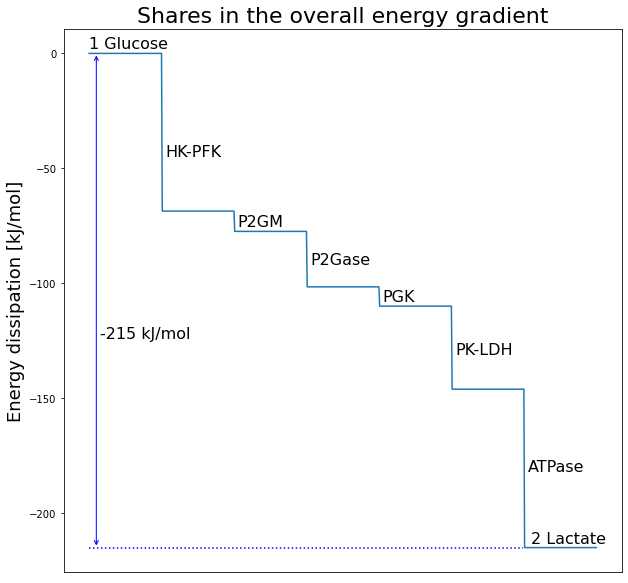

In [31]:
glycolytic_flux = fluxes_dict['v_HK_PFK']
start = 0
step_1 = start + dG_per_Glc['HK_PFK']
step_2 = step_1 + dG_per_Glc['P2GM']
step_3 = step_2 + dG_per_Glc['P2Gase']
step_4 = step_3 + dG_per_Glc['PGK']
step_5 = step_4 + dG_per_Glc['PK_LDH']
step_6 = step_5 + dG_per_Glc['ATPase']

dG_steps = [start, start, step_1, step_1, step_2, step_2, step_3, step_3, step_4, step_4, step_5, step_5, step_6, step_6]
timeline = np.linspace(0, len(dG_steps), len(dG_steps))
timeline = np.round(timeline, 0)
sequence = [1,2,2.01, 3, 3.01, 4, 4.01, 5, 5.01, 6, 6.01, 7, 7.01, 8]

plt.figure(figsize=(10,10))
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
# frame1.axes.spines['top'].set_visible(False)

plt.annotate('1 Glucose', (1,2), size = 16)
plt.annotate('HK-PFK', (2.05,-45), size = 16)
plt.annotate('P2GM', (3.05,-75.5), size = 16)
plt.annotate('P2Gase', (4.05,-92), size = 16)
plt.annotate('PGK', (5.05,-108), size = 16)
plt.annotate('PK-LDH', (6.05,-131), size = 16)
plt.annotate('ATPase', (7.05,-182), size = 16)
plt.annotate('2 Lactate', (7.1,-213.3), size = 16)

plt.hlines(y = min(dG_steps), xmin = min(sequence), xmax = 6.99,
               color = 'b', linestyle = 'dotted')

plt.annotate("",
            xy=(min(sequence)+0.1, min(dG_steps)), xycoords='data',
            xytext=(min(sequence)+0.1, max(dG_steps)), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3", color='b', lw=1),
            )
plt.annotate('-215 kJ/mol', (1.15, -124), size = 16)

plt.plot(sequence, dG_steps)
plt.ylabel('Energy dissipation [kJ/mol]', size = 18)
plt.title('Shares in the overall energy gradient', size = 22)
#plt.savefig('Shares in the overall energy gradient', bbox_inches='tight')
plt.show()

## calculation of the efficiency

In [32]:
catabolism = dGr_sum_per_time
anabolism = dG_per_time['ATPase']

efficiency = (anabolism)/catabolism

print('Efficiency:')
print(efficiency)

Efficiency:
0.32051260387099406


## Calculation of the efficiency for various k_ATPase values and resulting fluxes of anabolism

In [33]:
m.update_parameters(p)

k_ATPase_range = np.linspace(0.01, 2.5, 100)

efficiencies = []
J_As = []

for i in range(len(k_ATPase_range)):
    # update k_ATPase value
    m.update_parameter('k_ATPase', k_ATPase_range[i])
    
    # simulate to steady state
    t_ss_n, y_ss_n = s.simulate_to_steady_state()
    
    # get steady state concentrations and convert them 
    compounds_list_n = m.get_compounds()
    c_ss_n = {}
    for i in range(len(compounds_list_n)):
        comp = compounds_list_n[i] 
        value = y_ss_n[0, i]/1000  # mM -> M
        c_ss_n[comp] = value
        
    # calculate mass-action ratios
    Q_n_HK_PFK = ((c_ss_n['P13G']**2) * (c_ss_n['ADP']**2) * (c_NADH**2))/(c_Glc * (c_ss_n['ATP']**2) * (c_NAD**2) * (c_Pi**2))
    Q_n_PGK = (c_ss_n['PEP'] * c_ss_n['ATP'])/(c_ss_n['P13G'] * c_ss_n['ADP'])
    Q_n_PK_LDH = (c_Lac * c_ss_n['ATP'] * c_NAD)/(c_ss_n['PEP'] * c_ss_n['ADP'] * c_NADH)
    Q_n_P2GM = (c_ss_n['P23G'])/(c_ss_n['P13G'])
    Q_n_P2Gase = (c_ss_n['PEP'] * c_Pi)/(c_ss_n['P23G'])
    Q_n_AK = (c_ss_n['ADP']**2)/(c_ss_n['ATP'] * c_ss_n['AMP'])
    Q_n_ATPase = (c_ss_n['ADP'] * c_Pi)/(c_ss_n['ATP'])

    Qs_n = {
        'HK_PFK': Q_n_HK_PFK,
        'PGK': Q_n_PGK,
        'PK_LDH': Q_n_PK_LDH,
        'P2GM': Q_n_P2GM,
        'P2Gase': Q_n_P2Gase,
        'AK': Q_n_AK,
        'ATPase': Q_n_ATPase,
    }
    
    # calculate disequilibria 
    disequilibrium_n = {}
    
    for key in Qs_n.keys():
        value_disequilibrium = math.log(Qs_n[key]/Keqs[key])
        disequilibrium_n[key] = value_disequilibrium
        
    # calculate Gibbs free energies of reaction 
    dGr_dict_n = {}
    for key in disequilibrium_n.keys():
        dGr = RT * disequilibrium_n[key]
        dGr_dict_n[key] = dGr

        
    # get fluxes
    fluxes_dict_n = m.get_fluxes_dict(y_ss_n)
    
    # get energy dissipations over time
    dG_sum_per_time_n = 0
    for key in dGr_dict_n.keys():
        dGr = dGr_dict_n[key] * fluxes_dict_n['v_'+ key]
        dG_sum_per_time_n = dG_sum_per_time_n + dGr
    
    # calculate efficiency 
    catabolism_n = dG_sum_per_time_n
    
    J_A_n = fluxes_dict_n['v_ATPase'][0]
    dG_A_n = dGr_dict_n['ATPase'] * (-1)
    
    efficiency_n = (-J_A_n * dG_A_n)/catabolism
    
    efficiencies.append(efficiency_n)
    J_As.append(J_A_n)


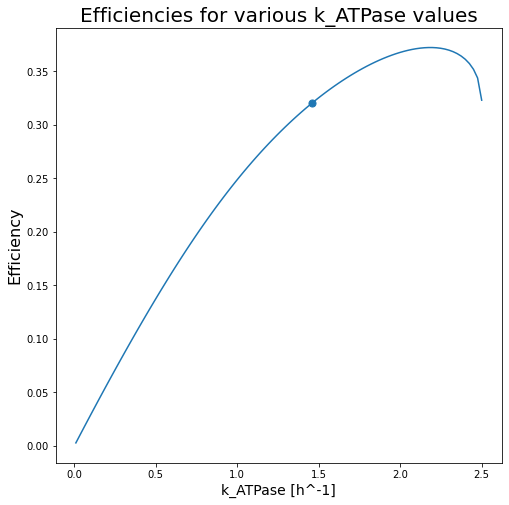

In [34]:
# plot in dependency of k_ATPase

plt.figure(figsize=(8,8))
plt.plot(k_ATPase_range, efficiencies)
plt.scatter(1.46, 0.3205, s=50)
plt.xlabel('k_ATPase [h^-1]', size = 14)
plt.ylabel('Efficiency', size = 16)
plt.title('Efficiencies for various k_ATPase values', size = 20)
# plt.savefig('Efficiencies for various k_ATPase values', bbox_inches='tight')
plt.show()

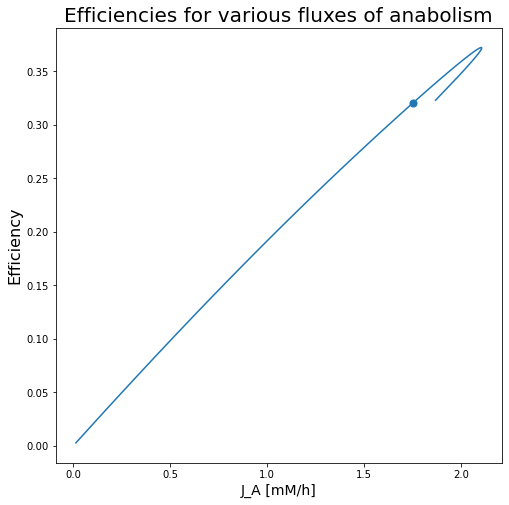

In [35]:
# plot in dependency of the flux of anabolism

plt.figure(figsize=(8,8))
plt.plot(J_As, efficiencies)
plt.scatter(1.752362, 0.3205, s=50)
plt.xlabel('J_A [mM/h]', size = 14)
plt.ylabel('Efficiency', size = 16)
plt.title('Efficiencies for various fluxes of anabolism', size = 20)
#plt.savefig('Efficiencies for various fluxes of anabolism', bbox_inches='tight')
plt.show()

## Calculation of the Efficiency for various k_P2GM values and the resulting flux through the bypass

In [36]:
m.update_parameters(p)

k_P2GM_range = np.linspace(0.1, 6100, 1000)

efficiencies_bypass = []
J_P2GM = []


for i in range(len(k_P2GM_range)):
    # update k_ATPase value
    m.update_parameter('k_P2GM', k_P2GM_range[i])
    
    # simulate to steady state
    t_ss_bypass, y_ss_bypass = s.simulate_to_steady_state()
    
    # get steady state concentrations and convert them 
    compounds_list_bypass = m.get_compounds()
    c_ss_bypass = {}
    for i in range(len(compounds_list_bypass)):
        comp = compounds_list_bypass[i] 
        value = y_ss_bypass[0, i]/1000  # mM -> M
        c_ss_bypass[comp] = value
        
    # calculate mass-action ratios
    Q_HK_PFK_bypass = ((c_ss_bypass['P13G']**2) * (c_ss_bypass['ADP']**2) * (c_NADH**2))/(c_Glc * (c_ss_bypass['ATP']**2) * (c_NAD**2) * (c_Pi**2))
    Q_PGK_bypass = (c_ss_bypass['PEP'] * c_ss_bypass['ATP'])/(c_ss_bypass['P13G'] * c_ss_bypass['ADP'])
    Q_PK_LDH_bypass = (c_Lac * c_ss_bypass['ATP'] * c_NAD)/(c_ss_bypass['PEP'] * c_ss_bypass['ADP'] * c_NADH)
    Q_P2GM_bypass = (c_ss_bypass['P23G'])/(c_ss_bypass['P13G'])
    Q_P2Gase_bypass = (c_ss_bypass['PEP'] * c_Pi)/(c_ss_bypass['P23G'])
    Q_AK_bypass = (c_ss_bypass['ADP']**2)/(c_ss_bypass['ATP'] * c_ss_bypass['AMP'])
    Q_ATPase_bypass = (c_ss_bypass['ADP'] * c_Pi)/(c_ss_bypass['ATP'])

    Qs_bypass = {
        'HK_PFK': Q_HK_PFK_bypass,
        'PGK': Q_PGK_bypass,
        'PK_LDH': Q_PK_LDH_bypass,
        'P2GM': Q_P2GM_bypass,
        'P2Gase': Q_P2Gase_bypass,
        'AK': Q_AK_bypass,
        'ATPase': Q_ATPase_bypass,
    }
    
    # calculate disequilibria 
    disequilibrium_bypass = {}
    
    for key in Qs_bypass.keys():
        value_disequilibrium = math.log(Qs_bypass[key]/Keqs[key])
        disequilibrium_bypass[key] = value_disequilibrium
        
    # calculate Gibbs free energies of reaction 
    dGr_dict_bypass = {}
    for key in disequilibrium_bypass.keys():
        dGr = RT * disequilibrium_bypass[key]
        dGr_dict_bypass[key] = dGr

        
    # get fluxes
    fluxes_dict_bypass = m.get_fluxes_dict(y_ss_bypass)
    
    # get energy dissipations over time
    dG_sum_per_time_bypass = 0
    for key in dGr_dict_bypass.keys():
        dGr = dGr_dict_bypass[key] * fluxes_dict_bypass['v_'+ key]
        dG_sum_per_time_bypass = dG_sum_per_time_bypass + dGr
    
    # calculate efficiency 
    catabolism_bypass = dG_sum_per_time_bypass
    
    J_A_bypass = fluxes_dict_bypass['v_ATPase'][0]
    dG_A_bypass = dGr_dict_bypass['ATPase'] * (-1)
    
    efficiency_bypass = (-J_A_bypass * dG_A_bypass)/catabolism
    
    efficiencies_bypass.append(efficiency_bypass)

    J_P2GM.append(fluxes_dict_bypass['v_P2GM'])

        
    


### See how the flux through the bypass changes in dependency of k_P2GM

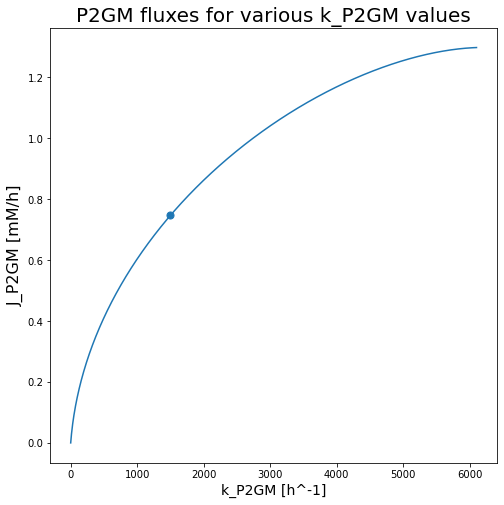

In [37]:
plt.figure(figsize=(8,8))
plt.plot(k_P2GM_range, J_P2GM)
plt.scatter(1500, 0.747273, s=50)
plt.xlabel('k_P2GM [h^-1]', size = 14)
plt.ylabel('J_P2GM [mM/h]', size = 16)
plt.title('P2GM fluxes for various k_P2GM values', size = 20)
# plt.savefig('P2GM fluxes for various k_P2GM values', bbox_inches='tight')
plt.show()

### plot the efficiency in dependency of k_P2GM and the flux through bypass, i.e. the P2GM

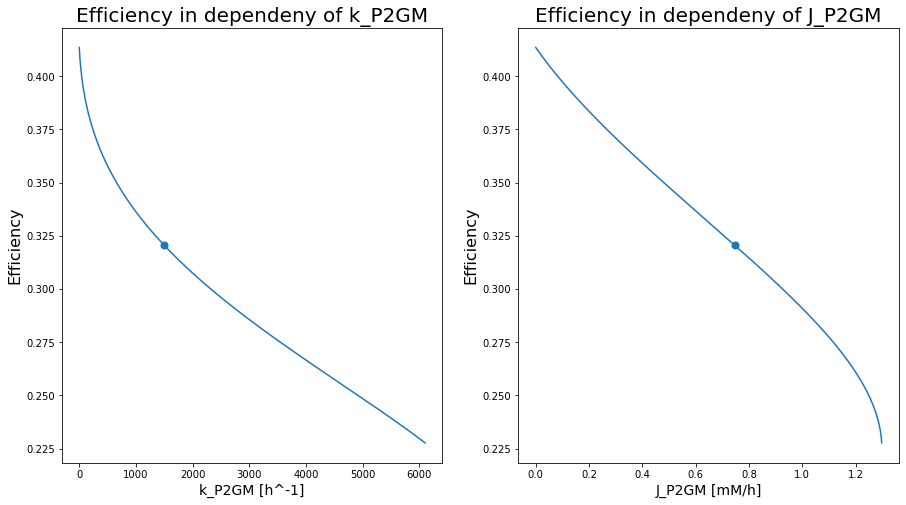

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

ax1.plot(k_P2GM_range, efficiencies_bypass)
ax1.set_xlabel('k_P2GM [h^-1]', size = 14)
ax1.set_ylabel('Efficiency', size = 16)
ax1.scatter(1500, 0.3205, s=50)

ax2.plot(J_P2GM, efficiencies_bypass)
ax2.set_xlabel('J_P2GM [mM/h]', size = 14)
ax2.set_ylabel('Efficiency', size = 16)
ax2.scatter(0.747273, 0.3205, s=50)

ax1.set_title('Efficiency in dependeny of k_P2GM', size = 20)
ax2.set_title('Efficiency in dependeny of J_P2GM', size = 20)

plt.show()